###### 20 November 2018, by Jeroen van Lidth de Jeude - [NETWORKS](http://networks.imtlucca.it/) -  [IMT School for Advanced Studies Lucca](https://www.imtlucca.it/jeroen.vanlidth)
# Exponential Random Graph Null Models for Graph Structures with Modular Hierarchies
For clustered data the null model can be taken to include information on the modular structure. In this notebook we provide code to solve a configuration null model in every block of the block structure of the adjacency matrix. We detail this approach in the paper: [*"Reconstructing Mesoscale Network Structures" - Jeroen van Lidth de Jeude, Riccardo Di Clemente, Guido Caldarelli, Fabio Saracco and Tiziano Squartini (15/05/2018)*](https://arxiv.org/abs/1805.06005) 

![arXiv article](article_header.png )

## Modular structures
Examples of modular structures are core-periphery and bow-tie-like structures. (Below showing the adjacency matrices representing the block structure - darker colors indicate a higher edge density.)
![block structures](block_structures.png )
It is these blocks of the adjacency matrices that we will model in this notebook.

## Null models
As detailed in the paper, we use the configuration model and include information for which nodes belong to which partition/block. We provide the code for both the Directed Configuration Model and the Reciprocated Configuration Model.

![null models](null_models.png )

# Code
This code consists of the usual Directed Configuration Model, Reciprocated Configuration Model, and their block verion alternatives. 

For the Block Directed Configuration Model we have to solve the:
    - *monopartite* DCM in the diagonal blocks (within clusters/blocks)
    - *bipartite* DCM in the off-diagonal blocks (between clusters)

The functions provided are therfore:
    - Monopartite:
        - system of equations of the monopartite DCM
        - numerical solver of the system of equations
    - Bipartite
        - system of equations of the bipartite DCM
        - numerical solver of the system of equations
    - Blocks: the function to solve the monopartite diagonal blocks and the bipartite off-diagonal blocks, and combine these into the overall matrix of edge probabilities

#### Potential Issues
Potential known issues in this script are:
    - blocks/clusters should be of at least size n=2, otherwise the code will error
    - as usual the numerical solving can bring problems. Different solvers can be tried if the standard solver does not converge

In [1]:
from numba import jit
import numpy as np

# For the numerical solver
from scipy.optimize import least_squares

## Functions
Some of the basic code looks long, but these are mostly tricks to improve the numerical solveing, like for nodes with zero in- or out-degree. 

In [2]:
@jit
def equations_to_solve_dcm(p, k_out, k_in):
    """DCM equations for numerical solver.

        Args:
            p: list of independent variables [x y]
            adjacency_matrix: numpy.array adjacency matrix to be solved

        Returns:
            numpy array of observed degree - expected degree

    """
    n_nodes = len(k_out)
    # print(len(p), len(k_out), len(k_in))
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:len(p)]
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero

    # Expected degrees
    k_out_exp = np.zeros(x.shape[0])
    k_in_exp = np.zeros(x.shape[0])

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            if i != j:
                k_out_exp[i] += (x[i] * y[j]) / (1 + x[i] * y[j])
                k_in_exp[i] += (x[j] * y[i]) / (1 + x[j] * y[i])

    k_out_nonzero = k_out[k_out != 0]
    k_in_nonzero = k_in[k_in != 0]
    k_out_exp_nonzero = k_out_exp[k_out != 0]
    k_in_exp_nonzero = k_in_exp[k_in != 0]

    f1 = k_out_nonzero - k_out_exp_nonzero
    f2 = k_in_nonzero - k_in_exp_nonzero

    return np.concatenate((f1, f2))


def numerically_solve_dcm(adjacency_matrix):
    """Solves the DCM numerically with least squares.
       Directed Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adjacency_matrix : numpy.array adjacency matrix (binary, square)

       Returns:
           numpy.array probability matrix with dcm probabilities
    """

    n_nodes = len(adjacency_matrix)

    # Rough estimate of initial values
    k_in = np.sum(adjacency_matrix, 0)
    k_out = np.sum(adjacency_matrix, 1)
    x_initial_values = k_out / np.sqrt(np.sum(k_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values = k_in / np.sqrt(np.sum(k_in) + 1)

    x_initial_values = x_initial_values[k_out != 0]
    y_initial_values = y_initial_values[k_in != 0]

    initial_values = np.concatenate((x_initial_values, y_initial_values))
    #print(len(adjacency_matrix), len(x_initial_values), len(y_initial_values))
    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_dcm,
                             x0=initial_values,
                             args=(k_out, k_in,),
                             bounds=boundslu,
                             max_nfev=1e2,
                             ftol=1e-5, xtol=1e-5, gtol=1e-5)
    print(x_solved.cost, x_solved.message)
    # Numerical solution checks
    assert x_solved.cost < 0.1, 'Numerical convergence problem: final cost function evaluation > 1'

    # Set extremely small values to zero
    # x_solved.x[x_solved.x < 1e-8] = 0

    p = x_solved.x
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:len(p)]
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero

    x_array = x
    y_array = y

    p_adjacency = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_adjacency[i, j] = x_array[i] * y_array[j] / (1 + x_array[i] * y_array[j])

    return p_adjacency


@jit
def equations_to_solve_dcm_bipartite(p, k_r_out, h_c_in, h_c_out, k_r_in):
    """DCM Bipartite equations for numerical solver.

    Args:
        p: list of independent variables [x y]
        m_adjacency_matrix: above diagonal rectangular matrix
        n_adjacency_matrix: under diagonal rectangular matrix


    Returns:
        numpy array of observed degree - expected degree

    """
    r = len(k_r_out)
    c = len(h_c_in)
    p = np.array(p)
    num_nonzero_kro = np.count_nonzero(k_r_out)
    num_nonzero_hci = np.count_nonzero(h_c_in)
    num_nonzero_hco = np.count_nonzero(h_c_out)
    num_nonzero_kri = np.count_nonzero(k_r_in)

    xrt_nonzero = p[0:num_nonzero_kro]
    ycb_nonzero = p[num_nonzero_kro:num_nonzero_kro + num_nonzero_hci]
    xcb_nonzero = p[num_nonzero_kro + num_nonzero_hci:num_nonzero_kro + num_nonzero_hci + num_nonzero_hco]
    yrt_nonzero = p[num_nonzero_kro + num_nonzero_hci + num_nonzero_hco:len(p)]
    xrt = np.zeros(r)
    xrt[k_r_out != 0] = xrt_nonzero
    ycb = np.zeros(c)
    ycb[h_c_in != 0] = ycb_nonzero
    xcb = np.zeros(c)
    xcb[h_c_out != 0] = xcb_nonzero
    yrt = np.zeros(r)
    yrt[k_r_in != 0] = yrt_nonzero

    # Expected degrees
    k_r_out_exp = np.zeros(r)
    h_c_in_exp = np.zeros(c)
    h_c_out_exp = np.zeros(c)
    k_r_in_exp = np.zeros(r)

    for r_i in np.arange(r):
        for c_i in np.arange(c):
            xrt_ycb = (xrt[r_i] * ycb[c_i]) / (1 + xrt[r_i] * ycb[c_i])
            k_r_out_exp[r_i] += xrt_ycb
            h_c_in_exp[c_i] += xrt_ycb

            xcb_yrt = (xcb[c_i] * yrt[r_i]) / (1 + xcb[c_i] * yrt[r_i])
            h_c_out_exp[c_i] += xcb_yrt
            k_r_in_exp[r_i] += xcb_yrt

    k_r_out_nonzero = k_r_out[k_r_out != 0]
    h_c_in_nonzero = h_c_in[h_c_in != 0]
    h_c_out_nonzero = h_c_out[h_c_out != 0]
    k_r_in_nonzero = k_r_in[k_r_in != 0]

    k_r_out_exp_nonzero = k_r_out_exp[k_r_out != 0]
    h_c_in_exp_nonzero = h_c_in_exp[h_c_in != 0]
    h_c_out_exp_nonzero = h_c_out_exp[h_c_out != 0]
    k_r_in_exp_nonzero = k_r_in_exp[k_r_in != 0]

    f1 = k_r_out_nonzero - k_r_out_exp_nonzero
    f2 = h_c_in_nonzero - h_c_in_exp_nonzero
    f3 = h_c_out_nonzero - h_c_out_exp_nonzero
    f4 = k_r_in_nonzero - k_r_in_exp_nonzero

    return np.concatenate((f1, f2, f3, f4))


def numerically_solve_dcm_bipartite_likelihood(m_adjacency_matrix, n_adjacency_matrix):
    """Solves the Bipartite DCM numerically with least squares.
       Bipartite Directed Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           m_adjacency_matrix: numpy.array above diagonal rectangular matrix (binary)
           n_adjacency_matrix: numpy.array under diagonal rectangular matrix (binary)

       Returns:
           loglikelihood of the configuration
    """

    def safe_ln(x):
        if x <= 0:
            return 0
        return np.log(x)

    # Observed degrees
    k_r_out = np.sum(m_adjacency_matrix, 1)
    h_c_in = np.sum(m_adjacency_matrix, 0)
    h_c_out = np.sum(n_adjacency_matrix, 1)
    k_r_in = np.sum(n_adjacency_matrix, 0)

    # Rough estimate of initial values
    x_initial_values_1 = k_r_out / np.sqrt(np.sum(k_r_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values_1 = h_c_in / np.sqrt(np.sum(h_c_in) + 1)
    x_initial_values_2 = h_c_out / np.sqrt(np.sum(h_c_out) + 1)
    y_initial_values_2 = k_r_in / np.sqrt(np.sum(k_r_in) + 1)

    x_initial_values_1 = x_initial_values_1[k_r_out != 0]
    y_initial_values_1 = y_initial_values_1[h_c_in != 0]
    x_initial_values_2 = x_initial_values_2[h_c_out != 0]
    y_initial_values_2 = y_initial_values_2[k_r_in != 0]

    initial_values = np.concatenate((x_initial_values_1, y_initial_values_1,
                                     x_initial_values_2, y_initial_values_2))
    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_dcm_bipartite,
                             x0=initial_values,
                             args=(k_r_out, h_c_in, h_c_out, k_r_in,),
                             bounds=boundslu,
                             max_nfev=1e4,
                             ftol=1e-15, xtol=1e-15, gtol=1e-15)
    print(x_solved.cost, x_solved.message)

    # Numerical solution checks
    assert x_solved.cost < 1, 'Numerical convergence problem: final cost function evaluation > 1'

    # Set extremely small values to zero for likelihood problems (log(very small number) = large)
    # x_solved.x[x_solved.x < 1e-7] = 0

    r = len(k_r_out)
    c = len(h_c_in)
    p = np.array(x_solved.x)
    num_nonzero_kro = np.count_nonzero(k_r_out)
    num_nonzero_hci = np.count_nonzero(h_c_in)
    num_nonzero_hco = np.count_nonzero(h_c_out)
    num_nonzero_kri = np.count_nonzero(k_r_in)

    xrt_nonzero = p[0:num_nonzero_kro]
    ycb_nonzero = p[num_nonzero_kro:num_nonzero_kro + num_nonzero_hci]
    xcb_nonzero = p[num_nonzero_kro + num_nonzero_hci:num_nonzero_kro + num_nonzero_hci + num_nonzero_hco]
    yrt_nonzero = p[num_nonzero_kro + num_nonzero_hci + num_nonzero_hco:len(p)]
    xrt = np.zeros(r)
    xrt[k_r_out != 0] = xrt_nonzero
    ycb = np.zeros(c)
    ycb[h_c_in != 0] = ycb_nonzero
    xcb = np.zeros(c)
    xcb[h_c_out != 0] = xcb_nonzero
    yrt = np.zeros(r)
    yrt[k_r_in != 0] = yrt_nonzero

    l_r = 0
    for r in np.arange(m_adjacency_matrix.shape[0]):
        l_r += (k_r_out[r] * safe_ln(xrt[r])) + (k_r_in[r] * safe_ln(yrt[r]))
    l_c = 0
    for c in np.arange(m_adjacency_matrix.shape[1]):
        l_c += (h_c_out[c] * safe_ln(xcb[c])) + (h_c_in[c] * safe_ln(ycb[c]))
    l_rc = 0
    for r in np.arange(m_adjacency_matrix.shape[0]):
        for c in np.arange(m_adjacency_matrix.shape[1]):
            l_rc += safe_ln((1 + xrt[r] * ycb[c]) * (1 + xcb[c] * yrt[r]))
    likelihood = l_r + l_c - l_rc
    
    #print(m_adjacency_matrix, n_adjacency_matrix)
    #print(xrt, ycb, xcb,yrt)
    p_m_adj = np.zeros_like(m_adjacency_matrix, dtype=np.float)
    for r in np.arange(m_adjacency_matrix.shape[0]):
        for c in np.arange(m_adjacency_matrix.shape[1]):
            p_m_adj[r,c] = (xrt[r]*ycb[c]) / (1+(xrt[r]*ycb[c]))
            
    p_n_adj = np.zeros_like(n_adjacency_matrix, dtype=np.float)
    for c in np.arange(m_adjacency_matrix.shape[1]):
        for r in np.arange(m_adjacency_matrix.shape[0]):
            p_n_adj[c,r] = (xcb[c]*yrt[r]) / (1+(xcb[c]*yrt[r]))
    
    return p_m_adj, p_n_adj, likelihood



In [3]:
def numerically_solve_block_dcm(adj, partitioning):
    """Solves the Bipartite DCM numerically with least squares for all blocks indicated 
        with the partitioning vector
       Bipartite Directed Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adj: numpy.array binary square adjacency matrix 
           partitioning: numpy.array integer vector of node belonging. e.g. [0,1,0,1],
           for nodes 0&2 belonging to cluster one and nodes 1&3 belonging to cluster 2

       Returns:
           p_adj: numpy.array square matrix of probabilities.
    """
    n_nodes = adj.shape[0]
    B = len(set(partitioning))
    
    p_adj = np.zeros_like(adj, dtype=np.float)
    for i in np.arange(B):
        for j in np.arange(B):
            if i <= j:
                adj_block = adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])]
                if i == j:  # Diagonal square block
                    if np.sum(adj_block) > 0:  # Block with links
                        p_adj_block = numerically_solve_dcm(adj_block)
                    else: # Block without links
                        p_adj_block = np.zeros_like(adj_block)
                    
                    p_adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])] = p_adj_block.copy()
                
                else:  # Off diagonal block
                    adj_block_lower = adj[np.ix_(np.where(partitioning==j)[0], np.where(partitioning==i)[0])]
                    if np.sum(adj_block) + np.sum(adj_block_lower) > 0:  # Block with links
                        p_m_adj, p_n_adj, likelihood = numerically_solve_dcm_bipartite_likelihood(adj_block,
                                                                                                  adj_block_lower)

                    else:
                        p_m_adj = np.zeros_like(adj_block)
                        p_n_adj = np.zeros_like(adj_block_lower)
                
                    p_adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])] = p_m_adj
                    p_adj[np.ix_(np.where(partitioning==j)[0], np.where(partitioning==i)[0])] = p_n_adj
                
    return p_adj
                
                

## Working Example: Clustered Graph with two blocks
In this example we generate a randomly filled adjacency matrix, with different edge-densities in the different blocks of the adjacency: we create a random graph with modular (clustered) structure. 

The functions for the null-model solving is:
    - `numerically_solve_block_dcm(adjacency_matrix, partitioning)` block model DCM
    - `numerically_solve_dcm(adjacency_matrix)` non-block DCM

In [4]:
n1 = 10  # Size first cluster
n2 = 8  # Size second cluster

a1 = (np.random.rand(n1,n1) < 0.7)  # Generate random matrix blocks
a2 = (np.random.rand(n1,n2) < 0.2)  # Low edge-density block
a3 = (np.random.rand(n2,n1) < 0.2) 
a4 = (np.random.rand(n2,n2) < 0.7)  # High edge-density block

adjacency_matrix = np.bmat([[a1, a2], 
                            [a3, a4]])  # Join blocks
np.fill_diagonal(adjacency_matrix,0)  # Prevent self-loops
adjacency_matrix = adjacency_matrix.astype(int)  # Force binary links
adjacency_matrix = np.asarray(adjacency_matrix)  # Format as np.ndarray instead of np.matrix

partitioning = np.concatenate([np.zeros(n1), np.ones(n2)])  # Cluster information

Now we compute the null models and visualise the result: the original matrix, the matrix of edge probabilities as predicted by the normal Directed Configuration Model, and the matix of edge probabilities as predicted by the block version of the DCM

In [5]:
# Loading matplotlib library for visualisation
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

For the block model, the function should also get the variable indicating the node-specific group information: the partitioning. This should be an array of length of the number of nodes, where all entries indicate to which cluster the node belongs. 

2.836651193583484e-09 `gtol` termination condition is satisfied.
1.4113214632469664e-30 `xtol` termination condition is satisfied.
6.117181701212196e-06 The maximum number of function evaluations is exceeded.
2.4268427920863096e-17 `gtol` termination condition is satisfied.


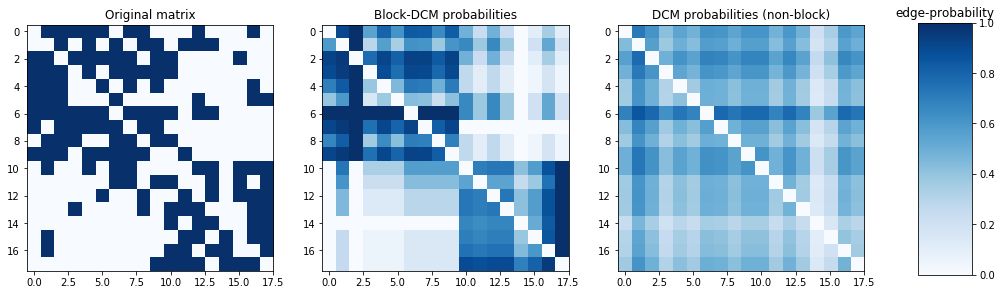

In [6]:
p_adj = numerically_solve_block_dcm(adjacency_matrix, partitioning)  # Solve block null model
p_dcm = numerically_solve_dcm(adjacency_matrix)  # Solve the non-block dcm

adjacencies = [adjacency_matrix, p_adj, p_dcm]
titles = ['Original matrix', 'Block-DCM probabilities', 'DCM probabilities (non-block)']
colormap = 'Blues'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(adjacencies[i], vmin=0, vmax=1, cmap = colormap)
    ax.set_title(titles[i])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_title('edge-probability')

plt.show()

## A note on model preformances
From a visual inspection of the adjacency matrices, it might seem that the null model encoding the block structure is the better fitting null model (because it visually recreates the block structure). Whether this is the case we answer in our paper ["Reconstructing Mesoscale Network Structures"](https://arxiv.org/abs/1805.06005) . (Short answer: the increase in number of fitting parameters that the encoding of the modular structure brings is not always worth it.)

## Reciprocated constraints null model
We can follow the same procedure, but with a different null model: the Reciprocated Configuration Model. This null model contraints the reciprocated degree sequences (in-degree, out-degree, reciprocated-degree). 

In [7]:
@jit
def equations_to_solve_rcm(p, k_out, k_in, k_rec):
    """RCM equations for numerical solver.

    Args:
        p: list of independent variables [x y z]
        adjacency_matrix: adjacency matrix to be solved

    Returns:
        numpy array of observed degree - expected degree

    """

    n_nodes = len(k_out)
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    num_y_nonzero_nodes = np.count_nonzero(k_in)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:num_x_nonzero_nodes + num_y_nonzero_nodes]
    z_nonzero = p[num_x_nonzero_nodes + num_y_nonzero_nodes:len(p)]
    # print(len(k_out),len(k_in),len(k_rec),len(x_nonzero),len(y_nonzero),len(z_nonzero))
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero
    z = np.zeros(n_nodes)
    z[k_rec != 0] = z_nonzero

    # Expected degrees
    k_out_exp = np.zeros(x.shape[0])
    k_in_exp = np.zeros(x.shape[0])
    k_rec_exp = np.zeros(x.shape[0])

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            if i != j:
                k_out_exp[i] += (x[i] * y[j]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])
                k_in_exp[i] += (x[j] * y[i]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])
                k_rec_exp[i] += (z[i] * z[j]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])

    k_out_nonzero = k_out[k_out != 0]
    k_in_nonzero = k_in[k_in != 0]
    k_rec_nonzero = k_rec[k_rec != 0]

    k_out_exp_nonzero = k_out_exp[k_out != 0]
    k_in_exp_nonzero = k_in_exp[k_in != 0]
    k_rec_exp_nonzero = k_rec_exp[k_rec != 0]

    f1 = k_out_nonzero - k_out_exp_nonzero
    f2 = k_in_nonzero - k_in_exp_nonzero
    f3 = k_rec_nonzero - k_rec_exp_nonzero

    return np.concatenate((f1, f2, f3))


def numerically_solve_rcm(adjacency_matrix):
    """Solves the RCM numerically with least squares.
       Reciprocated Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adjacency_matrix : numpy.array adjacency matrix (binary, square)

       Returns:
           numpy.array probability matrices with dcm probabilities:
                p_out_edges, p_in_edges, p_reciprocated_edges
    """

    n_nodes = len(adjacency_matrix)

    # Observed degrees
    k_rec = np.zeros(adjacency_matrix.shape[0], dtype=np.int)
    k_out = np.zeros(adjacency_matrix.shape[0], dtype=np.int)
    k_in = np.zeros(adjacency_matrix.shape[0], dtype=np.int)

    for i in np.arange(adjacency_matrix.shape[0]):
        for j in np.arange(adjacency_matrix.shape[0]):
            if i != j:
                k_rec_i = np.min((adjacency_matrix[i, j], adjacency_matrix[j, i]))
                k_out[i] += adjacency_matrix[i, j] - k_rec_i
                k_in[i] += adjacency_matrix[j, i] - k_rec_i
                k_rec[i] += k_rec_i

    # Rough estimate of initial values
    x_initial_values = k_out / np.sqrt(np.sum(k_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values = k_in / np.sqrt(np.sum(k_in) + 1)
    z_initial_values = k_rec / np.sqrt(np.sum(k_rec) + 1)

    x_initial_values = x_initial_values[k_out != 0]
    y_initial_values = y_initial_values[k_in != 0]
    z_initial_values = z_initial_values[k_rec != 0]

    initial_values = np.concatenate((x_initial_values, y_initial_values, z_initial_values))
    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_rcm,
                             x0=initial_values,
                             args=(k_out, k_in, k_rec,),
                             bounds=boundslu,
                             max_nfev=1e4,
                             ftol=1e-15, xtol=1e-15, gtol=1e-15)
    print(x_solved.cost, x_solved.message)
    # Numerical solution checks
    assert x_solved.cost < 1, 'Numerical convergence problem: final cost function evaluation > 1'

    p = np.array(x_solved.x)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    num_y_nonzero_nodes = np.count_nonzero(k_in)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:num_x_nonzero_nodes + num_y_nonzero_nodes]
    z_nonzero = p[num_x_nonzero_nodes + num_y_nonzero_nodes:len(p)]

    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero
    z = np.zeros(n_nodes)
    z[k_rec != 0] = z_nonzero

    x_array = x
    y_array = y
    z_array = z

    p_out = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_out[i, j] = x_array[i] * y_array[j] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    p_in = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_in[i, j] = x_array[j] * y_array[i] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    p_rec = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_rec[i, j] = z_array[i] * z_array[j] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    return p_out, p_in, p_rec

@jit
def equations_to_solve_rcm_bipartite(p, k_r_out, k_r_in, k_r_rec, h_c_in, h_c_out, h_c_rec):
    """RCM Bipartite equations for numerical solver.

    Args:
        p: list of independent variables [x y]
        m_adjacency_matrix: above diagonal rectangular matrix
        n_adjacency_matrix: under diagonal rectangular matrix


    Returns:
        numpy array of observed degree - expected degree

    """
    r = len(k_r_out)
    c = len(h_c_in)
    p = np.array(p)
    n0_kro = np.count_nonzero(k_r_out)
    n0_kri = np.count_nonzero(k_r_in)
    n0_krr = np.count_nonzero(k_r_rec)
    n0_hci = np.count_nonzero(h_c_in)
    n0_hco = np.count_nonzero(h_c_out)
    n0_hcr = np.count_nonzero(h_c_rec)

    xrt_nonzero = p[0:n0_kro]
    ycb_nonzero = p[n0_kro:n0_kro + n0_hci]
    zcb_nonzero = p[n0_kro + n0_hci:n0_kro + n0_hci + n0_hcr]
    xcb_nonzero = p[n0_kro + n0_hci + n0_hcr:n0_kro + n0_hci + n0_hcr + n0_hco]
    yrt_nonzero = p[n0_kro + n0_hci + n0_hcr + n0_hco:n0_kro + n0_hci + n0_hcr + n0_hco + n0_kri]
    zrt_nonzero = p[n0_kro + n0_hci + n0_hcr + n0_hco + n0_kri:len(p)]
    xrt = np.zeros(r)
    xrt[k_r_out != 0] = xrt_nonzero
    ycb = np.zeros(c)
    ycb[h_c_in != 0] = ycb_nonzero
    zcb = np.zeros(c)
    zcb[h_c_rec != 0] = zcb_nonzero
    xcb = np.zeros(c)
    xcb[h_c_out != 0] = xcb_nonzero
    yrt = np.zeros(r)
    yrt[k_r_in != 0] = yrt_nonzero
    zrt = np.zeros(r)
    zrt[k_r_rec != 0] = zrt_nonzero

    # Expected degrees
    k_r_out_exp = np.zeros(r)
    k_r_in_exp = np.zeros(r)
    k_r_rec_exp = np.zeros(r)
    h_c_in_exp = np.zeros(c)
    h_c_out_exp = np.zeros(c)
    h_c_rec_exp = np.zeros(c)

    for r_i in np.arange(r):
        for c_i in np.arange(c):
            xrt_ycb = xrt[r_i] * ycb[c_i] / (1 + xrt[r_i] * ycb[c_i] + xcb[c_i] * yrt[r_i] + zrt[r_i] * zcb[c_i])
            xcb_yrt = xcb[c_i] * yrt[r_i] / (1 + xrt[r_i] * ycb[c_i] + xcb[c_i] * yrt[r_i] + zrt[r_i] * zcb[c_i])
            zrt_zcb = zrt[r_i] * zcb[c_i] / (1 + xrt[r_i] * ycb[c_i] + xcb[c_i] * yrt[r_i] + zrt[r_i] * zcb[c_i])

            k_r_out_exp[r_i] += xrt_ycb
            k_r_in_exp[r_i] += xcb_yrt
            k_r_rec_exp[r_i] += zrt_zcb
            h_c_in_exp[c_i] += xrt_ycb
            h_c_out_exp[c_i] += xcb_yrt
            h_c_rec_exp[c_i] += zrt_zcb

    k_r_out_nonzero = k_r_out[k_r_out != 0]
    k_r_in_nonzero = k_r_in[k_r_in != 0]
    k_r_rec_nonzero = k_r_rec[k_r_rec != 0]
    h_c_in_nonzero = h_c_in[h_c_in != 0]
    h_c_out_nonzero = h_c_out[h_c_out != 0]
    h_c_rec_nonzero = h_c_rec[h_c_rec != 0]

    k_r_out_exp_nonzero = k_r_out_exp[k_r_out != 0]
    k_r_in_exp_nonzero = k_r_in_exp[k_r_in != 0]
    k_r_rec_exp_nonzero = k_r_rec_exp[k_r_rec != 0]
    h_c_in_exp_nonzero = h_c_in_exp[h_c_in != 0]
    h_c_out_exp_nonzero = h_c_out_exp[h_c_out != 0]
    h_c_rec_exp_nonzero = h_c_rec_exp[h_c_rec != 0]

    f1 = k_r_out_nonzero - k_r_out_exp_nonzero
    f2 = h_c_in_nonzero - h_c_in_exp_nonzero
    f3 = h_c_out_nonzero - h_c_out_exp_nonzero

    f4 = k_r_in_nonzero - k_r_in_exp_nonzero
    f5 = k_r_rec_nonzero - k_r_rec_exp_nonzero
    f6 = h_c_rec_nonzero - h_c_rec_exp_nonzero

    return np.concatenate((f1, f2, f3, f4, f5, f6))


def numerically_solve_rcm_bipartite_likelihood(m_adjacency_matrix, n_adjacency_matrix):
    """Solves the Bipartite RCM numerically with least squares.
       Bipartite Reciprocated Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           m_adjacency_matrix: numpy.array above diagonal rectangular matrix (binary)
           n_adjacency_matrix: numpy.array under diagonal rectangular matrix (binary)

       Returns:
           loglikelihood of the configuration
    """

    def safe_ln(x):
        if x <= 0:
            return 0
        return np.log(x)

    # Observed 'degrees'
    r = m_adjacency_matrix.shape[0]
    c = m_adjacency_matrix.shape[1]
    k_r_out = np.zeros(r, dtype=np.int)
    k_r_in = np.zeros(r, dtype=np.int)
    k_r_rec = np.zeros(r, dtype=np.int)
    h_c_in = np.zeros(c, dtype=np.int)
    h_c_out = np.zeros(c, dtype=np.int)
    h_c_rec = np.zeros(c, dtype=np.int)

    for r_i in np.arange(r):
        for c_i in np.arange(c):
            k_r_out[r_i] += m_adjacency_matrix[r_i, c_i] * (1 - n_adjacency_matrix[c_i, r_i])
            k_r_in[r_i] += n_adjacency_matrix[c_i, r_i] * (1 - m_adjacency_matrix[r_i, c_i])
            k_r_rec[r_i] += m_adjacency_matrix[r_i, c_i] * (n_adjacency_matrix[c_i, r_i])
    for c_i in np.arange(c):
        for r_i in np.arange(r):
            h_c_out[c_i] += n_adjacency_matrix[c_i, r_i] * (1 - m_adjacency_matrix[r_i, c_i])
            h_c_in[c_i] += m_adjacency_matrix[r_i, c_i] * (1 - n_adjacency_matrix[c_i, r_i])
            h_c_rec[c_i] += m_adjacency_matrix[r_i, c_i] * (n_adjacency_matrix[c_i, r_i])

    # Rough estimate of initial values
    x_initial_values_1 = k_r_out / np.sqrt(np.sum(k_r_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values_1 = h_c_in / np.sqrt(np.sum(h_c_in) + 1)
    z_initial_values_1 = h_c_rec / np.sqrt(np.sum(h_c_rec) + 1)
    x_initial_values_2 = h_c_out / np.sqrt(np.sum(h_c_out) + 1)
    y_initial_values_2 = k_r_in / np.sqrt(np.sum(k_r_in) + 1)
    z_initial_values_2 = k_r_rec / np.sqrt(np.sum(k_r_rec) + 1)

    x_initial_values_1 = x_initial_values_1[k_r_out != 0]
    y_initial_values_1 = y_initial_values_1[h_c_in != 0]
    z_initial_values_1 = z_initial_values_1[h_c_rec != 0]
    x_initial_values_2 = x_initial_values_2[h_c_out != 0]
    y_initial_values_2 = y_initial_values_2[k_r_in != 0]
    z_initial_values_2 = z_initial_values_2[k_r_rec != 0]

    initial_values = np.concatenate((x_initial_values_1, y_initial_values_1,
                                     z_initial_values_1,
                                     x_initial_values_2, y_initial_values_2,
                                     z_initial_values_2))

    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_rcm_bipartite,
                             x0=initial_values,
                             args=(k_r_out, k_r_in, k_r_rec, h_c_in, h_c_out, h_c_rec,),
                             bounds=boundslu,
                             max_nfev=1e4,
                             ftol=1e-15, xtol=1e-15, gtol=1e-15)
    print(x_solved.cost, x_solved.message)
    # Numerical solution checks
    assert x_solved.cost < 1, 'Numerical convergence problem: final cost function evaluation > 1'

    # Set extremely small values to zero for likelihood problems (log(very small number) = large)
    # x_solved.x[x_solved.x < 1e-7] = 0

    r = len(k_r_out)
    c = len(h_c_in)
    p = np.array(x_solved.x)
    n0_kro = np.count_nonzero(k_r_out)
    n0_kri = np.count_nonzero(k_r_in)
    n0_krr = np.count_nonzero(k_r_rec)
    n0_hci = np.count_nonzero(h_c_in)
    n0_hco = np.count_nonzero(h_c_out)
    n0_hcr = np.count_nonzero(h_c_rec)

    xrt_nonzero = p[0:n0_kro]
    ycb_nonzero = p[n0_kro:n0_kro + n0_hci]
    zcb_nonzero = p[n0_kro + n0_hci:n0_kro + n0_hci + n0_hcr]
    xcb_nonzero = p[n0_kro + n0_hci + n0_hcr:n0_kro + n0_hci + n0_hcr + n0_hco]
    yrt_nonzero = p[n0_kro + n0_hci + n0_hcr + n0_hco:n0_kro + n0_hci + n0_hcr + n0_hco + n0_kri]
    zrt_nonzero = p[n0_kro + n0_hci + n0_hcr + n0_hco + n0_kri:len(p)]
    xrt = np.zeros(r)
    xrt[k_r_out != 0] = xrt_nonzero
    ycb = np.zeros(c)
    ycb[h_c_in != 0] = ycb_nonzero
    zcb = np.zeros(c)
    zcb[h_c_rec != 0] = zcb_nonzero
    xcb = np.zeros(c)
    xcb[h_c_out != 0] = xcb_nonzero
    yrt = np.zeros(r)
    yrt[k_r_in != 0] = yrt_nonzero
    zrt = np.zeros(r)
    zrt[k_r_rec != 0] = zrt_nonzero

    l_r = 0
    for r in np.arange(m_adjacency_matrix.shape[0]):
        l_r += k_r_out[r] * safe_ln(xrt[r]) + k_r_in[r] * safe_ln(yrt[r]) + k_r_rec[r] * safe_ln(zrt[r])
    l_c = 0
    for c in np.arange(m_adjacency_matrix.shape[1]):
        l_c += h_c_out[c] * safe_ln(xcb[c]) + h_c_in[c] * safe_ln(ycb[c]) + h_c_rec[c] * safe_ln(zcb[c])
    l_rc = 0
    for r in np.arange(m_adjacency_matrix.shape[0]):
        for c in np.arange(m_adjacency_matrix.shape[1]):
            l_rc += safe_ln(1 + xrt[r] * ycb[c] + xcb[c] * yrt[r] + zrt[r] * zcb[c])

    likelihood = l_r + l_c - l_rc
    
    # Probability matrices    
    p_out = np.zeros_like(m_adjacency_matrix, dtype=np.float)
    for r in np.arange(m_adjacency_matrix.shape[0]):
        for c in np.arange(m_adjacency_matrix.shape[1]):
            denominator = (1 + xrt[r] * ycb[c] + xcb[c] * yrt[r] + zrt[r] * zcb[c])
            p_out[r,c] = (xrt[r] * ycb[c]) / denominator
            
    p_in = np.zeros_like(n_adjacency_matrix, dtype=np.float)
    for c in np.arange(m_adjacency_matrix.shape[1]):
        for r in np.arange(m_adjacency_matrix.shape[0]):
            denominator = (1 + xrt[r] * ycb[c] + xcb[c] * yrt[r] + zrt[r] * zcb[c])
            p_in[c,r] = (xcb[c] * yrt[r]) / denominator
            
    p_rec = np.zeros_like(m_adjacency_matrix, dtype=np.float)
    for r in np.arange(m_adjacency_matrix.shape[0]):
        for c in np.arange(m_adjacency_matrix.shape[1]):
            denominator = (1 + xrt[r] * ycb[c] + xcb[c] * yrt[r] + zrt[r] * zcb[c])
            p_rec[r,c] = (zrt[r] * zcb[c]) / denominator
    
    p_m = p_out + p_rec
    p_n = p_in + np.transpose(p_rec)
    
    return p_m, p_n, likelihood

In [8]:
def numerically_solve_block_rcm(adj, partitioning):
    """Solves the Bipartite RCM numerically with least squares for all blocks indicated 
        with the partitioning vector
       Bipartite Reciprocated Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adj: numpy.array binary square adjacency matrix 
           partitioning: numpy.array integer vector of node belonging. e.g. [0,1,0,1],
           for nodes 0&2 belonging to cluster one and nodes 1&3 belonging to cluster 2

       Returns:
           p_adj: numpy.array square matrix of probabilities.
    """
    n_nodes = adj.shape[0]
    B = len(set(partitioning))
    
    p_adj = np.zeros_like(adj, dtype=np.float)
    for i in np.arange(B):
        for j in np.arange(B):
            if i <= j:
                adj_block = adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])]
                if i == j:  # Diagonal square block
                    if np.sum(adj_block) > 0:  # Block with links
                        p_out, p_in, p_rec = numerically_solve_rcm(adj_block)
                        p_adj_block = p_out + p_in + p_rec
                    else: # Block without links
                        p_adj_block = np.zeros_like(adj_block)
                    
                    p_adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])] = p_adj_block.copy()
                
                else:  # Off diagonal block
                    adj_block_lower = adj[np.ix_(np.where(partitioning==j)[0], np.where(partitioning==i)[0])]
                    if np.sum(adj_block) + np.sum(adj_block_lower) > 0:  # Block with links
                        p_m_adj, p_n_adj, likelihood = numerically_solve_rcm_bipartite_likelihood(adj_block,
                                                                                                  adj_block_lower)

                    else:
                        p_m_adj = np.zeros_like(adj_block)
                        p_n_adj = np.zeros_like(adj_block_lower)
                
                    p_adj[np.ix_(np.where(partitioning==i)[0], np.where(partitioning==j)[0])] = p_m_adj
                    p_adj[np.ix_(np.where(partitioning==j)[0], np.where(partitioning==i)[0])] = p_n_adj
                
    return p_adj
                
                

## Example - block structures

In [9]:
n1 = 10  # Size first cluster
n2 = 8  # Size second cluster

a1 = (np.random.rand(n1,n1) < 0.7)  # Generate random matrix blocks
a2 = (np.random.rand(n1,n2) < 0.2)  # Low edge-density block
a3 = (np.random.rand(n2,n1) < 0.2) 
a4 = (np.random.rand(n2,n2) < 0.7)  # High edge-density block

adjacency_matrix = np.bmat([[a1, a2], 
                            [a3, a4]])  # Join blocks
np.fill_diagonal(adjacency_matrix,0)  # Prevent self-loops
adjacency_matrix = adjacency_matrix.astype(int)  # Force binary links
adjacency_matrix = np.asarray(adjacency_matrix)  # Format as np.ndarray instead of np.matrix

partitioning = np.concatenate([np.zeros(n1), np.ones(n2)])  # Cluster information

5.703521659355902e-11 The maximum number of function evaluations is exceeded.
5.053640174072107e-31 `gtol` termination condition is satisfied.
2.86386666418666e-10 The maximum number of function evaluations is exceeded.
6.064368208886528e-30 `xtol` termination condition is satisfied.


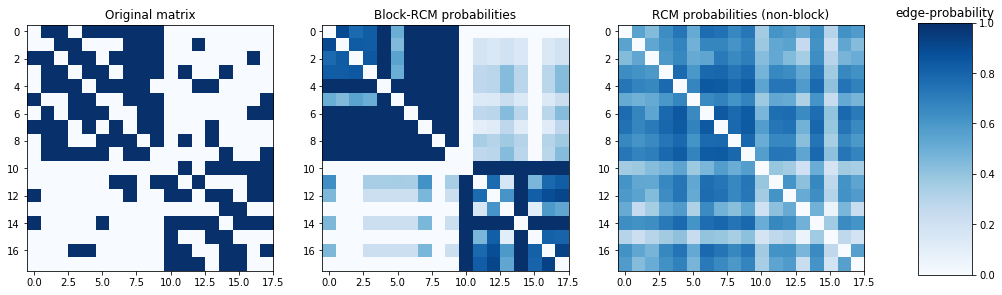

In [10]:
p_block_rcm = numerically_solve_block_rcm(adjacency_matrix, partitioning)  # Solve block null model
p_out, p_in, p_rec = numerically_solve_rcm(adjacency_matrix)  # Solve the non-block dcm
p_rcm = p_in + p_out + p_rec

adjacencies = [adjacency_matrix, p_block_rcm, p_rcm]
titles = ['Original matrix', 'Block-RCM probabilities', 'RCM probabilities (non-block)']
colormap = 'Blues'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(adjacencies[i], vmin=0, vmax=1, cmap = colormap)
    ax.set_title(titles[i])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_title('edge-probability')

plt.show()

### Useful links
This work was done within the [NETWORKS](http://networks.imtlucca.it/) research group at [IMT School for Advanced Studies Lucca](http://www.imtlucca.it/) with [Tiziano Squartini](https://www.imtlucca.it/tiziano.squartini), [Guido Caldarelli](http://www.guidocaldarelli.com/), [Fabio Saracco](https://www.imtlucca.it/fabio.saracco) and [Riccardo Di Clemente](http://www.riccardodiclemente.com/) at UCL . 

The Maximum Entropy null models are based on the many works of the collaborators mentioned above, see also [Maximum-Entropy Networks](https://www.springer.com/it/book/9783319694368), [The Statistical Physics of Real-World Networks](https://arxiv.org/abs/1810.05095) and [Analytical maximum-likelihood method to detect patterns in real networks](http://iopscience.iop.org/article/10.1088/1367-2630/13/8/083001/meta). 

For more information, please check out our [paper](https://arxiv.org/abs/1805.06005). 